## AlexNet

##### 모델 구조

- 'ILSVRC 2012'에서 우승한 CNN 구조

<img src="https://t1.daumcdn.net/cfile/tistory/99FEB93C5C80B5192E" width="700px">

---

##### (1) 라이브러리 호출

In [43]:
# 모델 학습의 진행 상태 확인을 위한 라이브러리
!pip install --user tqdm

In [44]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import os
import time
import random
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

from tqdm import tqdm_notebook as tqdm

##### (2) 이미지 데이터 내려받기

In [45]:
!git clone 'https://github.com/gilbutITbook/080289.git'

fatal: destination path '080289' already exists and is not an empty directory.


In [46]:
cat_directory = r'/content/080289/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'/content/080289/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [47]:
random.seed(2023)
random.shuffle(correct_images_filepaths) # 이미지 파일을 랜덤으로 섞음

train_images_filepaths = correct_images_filepaths[:400] # 학습 이미지 400장
val_images_filepaths = correct_images_filepaths[400:-10] # 검증 이미지 92장
test_images_filepaths = correct_images_filepaths[-10:] # 테스트 이미지 10장

len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths)

(400, 92, 10)

##### (3) 이미지 데이터 전처리

In [48]:
# 전처리 기법 클래스
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

        }

    def __call__(self, img, phase): # 인스턴스 자체를 호출하면 해당 함수의 return 값이 반환됨
        return self.data_transform[phase](img)

In [49]:
# 데이터셋 클래스
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list # 이미지 파일 목록
        self.transform = transform # 전처리 기법
        self.phase = phase # 학습/테스트

    def __len__(self):
        return len(self.file_list) # 데이터셋의 전체 길이 반환

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase) # 전처리 적용
        label = img_path.split('/')[-1].split('.')[0] # 파일명에서 레이블 추출

        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [50]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [51]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

*Dataset*

- X : 이미지 데이터

  - (3x256x256)
  
  - AlexNet은 **깊은** 네트워크로 이미지 크기 **256** 사용 (더 작으면 Pooling으로 feature map이 계속 작아져 오류 발생 가능)

In [55]:
train_dataset.__getitem__(77)[0]
train_dataset.__getitem__(77)[0].size()

torch.Size([3, 256, 256])

- y : 레이블

  - Dog/Cat

In [56]:
train_dataset.__getitem__(77)[1]

1

*DataLoader*

In [57]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloader_dict = {'train' : train_dataloader, 'val' : val_dataloader}

In [58]:
inputs, label = next(iter(train_dataloader))

- batch_size = 32

  - 한 번에 이미지 32장씩 처리

In [59]:
inputs.size()

torch.Size([32, 3, 256, 256])

In [60]:
label

tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0])

##### (4) 모델 생성

In [67]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True), # inplace=True : 기존 값을 대체함
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6)) # Pooling 이후 출력의 크기를 정의함

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [68]:
model = AlexNet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [69]:
# 모델 출력을 위한 라이브러리
!pip install torchsummary

In [71]:
from torchsummary import summary

summary(model.to(torch.device('cuda')), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

##### (5) 파라미터 설정

In [72]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [74]:
model = model.to(device)
criterion = criterion.to(device)
num_epoch = 10

##### (6) 모델 학습

In [75]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print(f"Epoch {epoch+1}/{num_epoch}")
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} ACC: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time()
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return model

In [76]:
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-75-872c5ae91016>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 ACC: 0.4950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 ACC: 0.5217
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 ACC: 0.4825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 ACC: 0.5326
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 ACC: 0.4750


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 ACC: 0.4674
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 ACC: 0.4850


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 ACC: 0.4783
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 ACC: 0.4625


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 ACC: 0.4783
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 ACC: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 ACC: 0.5000
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 ACC: 0.5300


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 ACC: 0.4891
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 ACC: 0.4725


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 ACC: 0.4783
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 ACC: 0.4950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 ACC: 0.4783
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 ACC: 0.4925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 ACC: 0.5217
Training complete in 28226279m 54s
Best val Acc: 0.532609


##### (7) 모델 테스트

In [77]:
id_list = []
pred_list = []
_id = 0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

result = pd.DataFrame({
    'id' : id_list,
    'label' : pred_list,
})

result.sort_values(by='id', inplace=True)
result.reset_index(drop=True, inplace=True)

result.to_csv('/content/080289/chap06/data/AlexNet', index=False)

<ipython-input-77-1c0e2fb62d0c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [78]:
result.head(10)

,id,label
0,135,0.500216
1,153,0.500259
2,196,0.500650
3,245,0.500084
4,36,0.499945
5,5,0.501428
6,52,0.500002
7,77,0.500935
8,79,0.500197
9,95,0.500238


In [79]:
class_ = classes = {0 : 'cat', 1 : 'dog'}

In [80]:
# 시각화를 위한 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(result['id'].values)
        label = result.loc[result['id'] == a, 'label'].values[0]

        if label > 0.5:
            label = 1
        else:
            label = 0

        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()

    plt.tight_layout()
    plt.show()

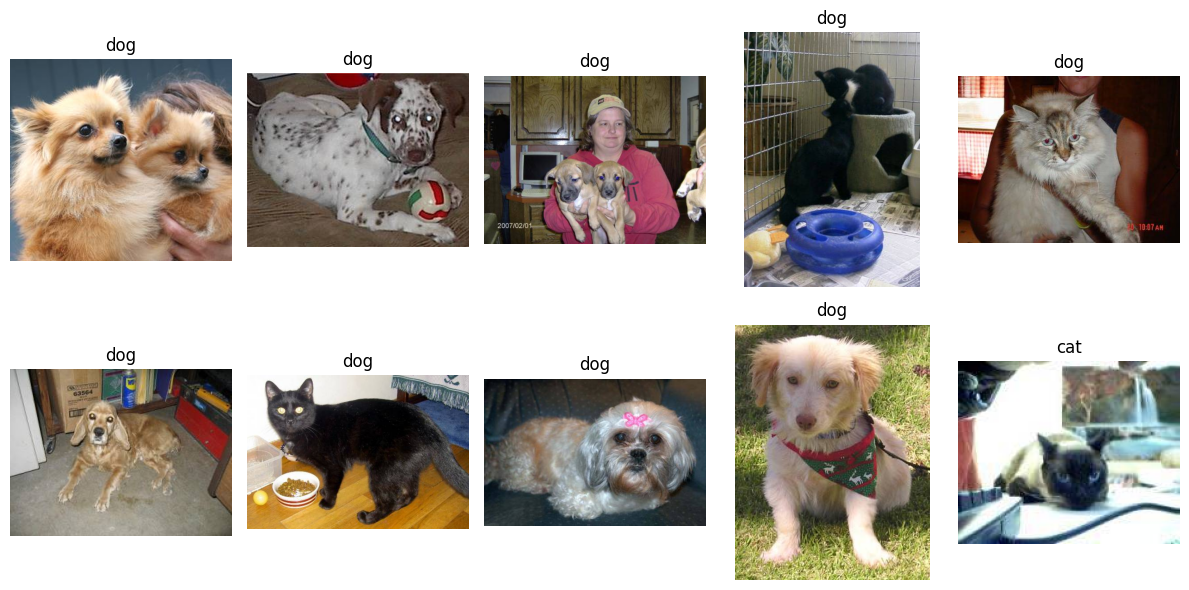

In [81]:
display_image_grid(test_images_filepaths)